In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import  PorterStemmer
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.io as pio

import pickle
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.preprocessing import  LabelEncoder
from sklearn.decomposition import NMF
import re
import time

In [2]:
pio.renderers.default = "png"
pio.renderers.width = 800
pio.renderers.height = 600

In [3]:
df = pd.read_csv('data/text/bbc.csv')
df['short'] = df['text'].str[:65]

In [4]:
def eng_clean(document):
    text = re.sub(r'http\S+', ' ', document, flags=re.MULTILINE)
    text = BeautifulSoup(text, "lxml").text

    for sign in ['\n', '\x0c']:
        text = text.replace(sign, ' ')

    text = re.sub('[^a-zA-Z]+', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = ' '.join([i for i in text.split()])

    return text.lower().strip()

In [5]:
stemmer = PorterStemmer()
stop_stem = set([stemmer.stem(word) for word in stopwords.words('english')])

tfidf = TfidfVectorizer(lowercase = False,
                        ngram_range = (1, 1),
                        min_df = 2,
                        max_df = 0.9)

In [6]:
start = time.time()

df['text'] = df['text'].astype(str)
end1 = time.time()
print("to string: ", round(end1 - start,2))

df['text'] = df['text'].apply(lambda x : eng_clean(x))

end2 = time.time()
print("clean: ", round(end2 - end1,2))

df['text'] = df['text'].apply(lambda x : [word for word in x.split() if len(word) > 1])
end3 = time.time()
print("tokenize: ", round(end3 - end2,2))

dog = stemmer.stem('dogs')

df['text'] = df['text'].apply(lambda x : [stemmer.stem(word) for word in x])
end4 = time.time()
print("stem: ", round(end4 - end3,2))

df['text'] = df['text'].apply(lambda x : [word for word in x if word not in stop_stem])
end5 = time.time()
print("remove stopwords: ", round((end5 - end4),2))

df['text'] = df['text'].apply(lambda x : " ".join(x))

end = time.time()
print("total time: ", str(round((end - start),2))+'s')


to string:  0.0
clean:  0.95
tokenize:  0.1
stem:  11.71
remove stopwords:  0.07
total time:  12.84s


In [7]:
encoder = LabelEncoder()
encoder.fit(df['category'])
keys = encoder.classes_
values = encoder.transform(encoder.classes_)
cat_to_int = dict(zip(keys, values))
int_to_cat = dict(zip(values, keys))

print(cat_to_int)
print(int_to_cat)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}


In [8]:
n_samples = 2000
n_features = 1000
n_components = 5
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features)

In [10]:
tfidf = tfidf_vectorizer.fit_transform(df['text'])

In [11]:
nmf = NMF(n_components=n_components, random_state=1, beta_loss='kullback-leibler', solver='mu',
          alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: said year compani would firm new market could report month share countri expect sale bank last price also deal european
Topic #1: game play win player england match first final team injuri cup champion time second world club side coach season old
Topic #2: film award star music best show band actor nomin oscar includ album festiv chart year movi song singer top releas
Topic #3: labour elect parti blair tori brown said minist govern lord howard vote would tax prime say chancellor campaign britain plan
Topic #4: use peopl mobil phone technolog comput game user softwar servic digit net network site system mail microsoft video broadband devic



In [12]:
nmf_topicspace = nmf.transform(tfidf)
cats = nmf_topicspace.argmax(axis=1)

In [13]:
#this dict has to be manually defined based off discovered topics
mydict = {0:'business', 1: 'sports', 2: 'entertainment', 3: 'politics', 4: 'technology'}
catsfixed = np.vectorize(mydict.get)(cats)
tfidf_vectorizer.transform([df.iloc[0]['text']])
nmf.transform(tfidf_vectorizer.transform([df.iloc[0]['text']]))

array([[4.32612920e-02, 6.09714460e-05, 1.03943897e-02, 2.29745838e-10,
        1.72063436e-01]])

In [14]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(nmf_topicspace)
x_values = tsne_results[:,1]
y_values = tsne_results[:,0]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.004s...
[t-SNE] Computed neighbors for 2225 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.005904
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.034267
[t-SNE] KL divergence after 300 iterations: 0.867637


In [15]:
df.columns

Index(['category', 'text', 'short'], dtype='object')

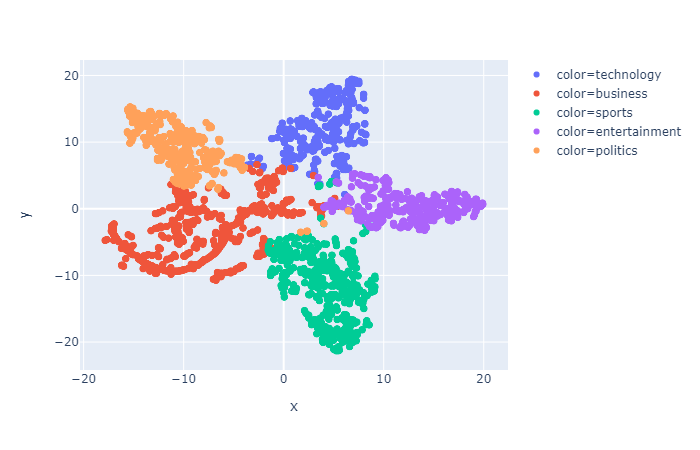

In [16]:
fig = px.scatter(df, x=x_values, y=y_values, color=catsfixed)#, hover_data=['short'])
fig.show()

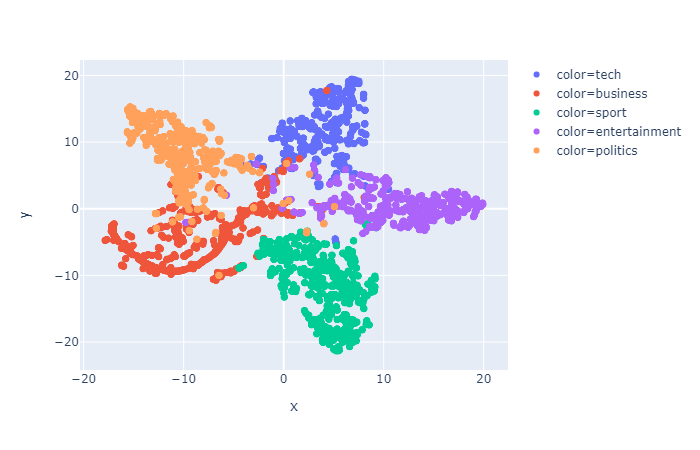

In [17]:
fig = px.scatter(df, x=x_values, y=y_values, color='category')\
                .for_each_trace(lambda t: t.update(name=t.name.replace("category=","color=")))#, hover_data=['short'])
fig.show()